In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torchvision import transforms
import torchvision.models as models  
from torchvision.transforms import Resize, RandomAffine, ToTensor, ToPILImage,  RandomErasing

from transformers import BertTokenizer, BertConfig, BertForSequenceClassification, get_cosine_schedule_with_warmup

import random
from PIL import Image, ImageEnhance 
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import timm

In [2]:
# CSV FILE PATHS MAPPING
# Paths to the CSV files and image folder
test_csv_path = 'bookcover30/Task1/book30-listing-test.csv'
image_folder = 'bookcover30/bookcover_images'

# Load train and test data from CSV files
test_data = pd.read_csv(test_csv_path, header=None, encoding='ISO-8859-1')

# Extract text, label, and filename columns
# Column indices are based on the CSV structure 0-based
# Titles are in column 4
# Labels are in column 7
# Image filenames are in column 2

test_texts = test_data.iloc[:, 3].tolist()
test_titles = test_data.iloc[:, 3].tolist()
test_labels = test_data.iloc[:, 6].tolist()
test_filenames = test_data.iloc[:, 1].tolist() 

# Prepend the image folder path to the filenames for both train and test data
test_filenames = [os.path.join(image_folder, fname) for fname in test_filenames]

# Get the unique labels and create a mapping
label_names = [str(label) for label in sorted(np.unique(test_labels))]
label_to_index = {name: index for index, name in enumerate(label_names)}

# Encode the labels
test_labels_encoded = np.array([label_to_index[label] for label in test_labels])

In [3]:
# COLOR SPACE CONVERSION
COLOR_CONVERSIONS = {
    "RGB": None,
    "XYZ": cv2.COLOR_RGB2XYZ,
    "YCbCr": cv2.COLOR_RGB2YCrCb,
    "LAB": cv2.COLOR_RGB2Lab,
    "HSV": cv2.COLOR_RGB2HSV,
    "YUV": cv2.COLOR_RGB2YUV,
    "LUV": cv2.COLOR_RGB2Luv
}

def convert_color_space(image, color_space):
    """Convert RGB image to a specified color space."""
    if color_space == "RGB":
        return image
    return cv2.cvtColor(image, COLOR_CONVERSIONS[color_space])

In [4]:
# DATA AUGMENTATION
def data_augmentation(image, rotation=False, blur=False, affine=False):
    image = Image.fromarray(image)  # Convert NumPy to PIL for PIL-based transforms
    pil_transforms = []  # Define list for PIL-based transforms

    # 🔹 Random Rotation
    if rotation:
        angle = np.random.uniform(-15, 15)
        image = image.rotate(angle)

    # 🔹 Random Affine Transformation (Shear)
    if affine:
        pil_transforms.append(RandomAffine(degrees=0, shear=10))

    # Apply PIL-based transformations AFTER adding them
    if pil_transforms:
        image = transforms.Compose(pil_transforms)(image)

    # Convert back to NumPy after augmentations
    image = np.array(image)

    # 🔹 Apply Gaussian Blur
    if blur:
        image = cv2.GaussianBlur(image, (5, 5), 0)

    return image  


In [5]:
# PREPROCESSING
def preprocess_image(image_path, color_spaces, img_size=(224, 224), augmentations=None, is_test=False):
    bgr_image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    tensors = []
    for space in color_spaces:
        converted = convert_color_space(rgb_image, space)  # Convert to target color space
        
        # 🔹 Convert to PIL before applying PIL-based augmentations
        image = Image.fromarray(converted)
        
        # 🔹 Apply augmentations only during training (excluding "erasing")
        if not is_test and augmentations:
            aug_params = {k: v for k, v in augmentations.items() if k != "erasing"}  # Exclude "erasing"
            converted = data_augmentation(np.array(image), **aug_params)  # Ensure NumPy format

        # Resize AFTER augmentations
        resized = cv2.resize(converted, img_size, interpolation=cv2.INTER_LINEAR)

        # Convert to PyTorch tensor
        tensor_image = ToTensor()(Image.fromarray(resized))

        # 🔹 Apply `RandomErasing` (Only in training mode)
        if not is_test and augmentations.get("erasing", False):
            random_erasing = RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0)
            tensor_image = random_erasing(tensor_image)

        tensors.append(tensor_image)
    
    return tensors

In [6]:
# DATASET FUNCTIONS

class TestDataset(Dataset):
    def __init__(self, image_paths, titles, tokenizer, max_len, labels, color_spaces, img_size):
        self.image_paths = image_paths
        self.labels = labels
        self.color_spaces = color_spaces
        self.img_size = img_size
        
        self.titles = titles
        self.tokenizer = tokenizer
        
        self.max_len = max_len

    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Text data (Book title)
        book_title = self.titles[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            book_title,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        image_tensors = preprocess_image(image_path, self.color_spaces, self.img_size, is_test=True)
        text_input_id = encoding["input_ids"].squeeze(0)
        text_attention_mask = encoding["attention_mask"].squeeze(0)

        # 🔹 If only one model is used, return a single tensor instead of a list
        if len(image_tensors) == 1:
            return image_tensors[0], text_input_id, text_attention_mask, label  # Return a single tensor
        
        return image_tensors, text_input_id, text_attention_mask, label  # Return multiple tensors for Parallel-ViT setup

In [7]:
# DATASET INITIALIZATION
# Define color spaces (Same for Train & Test)
color_spaces = ["RGB", "XYZ"]
img_size = (224, 224)

# Initialize tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128

# Test Dataset (Same Preprocessing but No Augmentations)
test_dataset = TestDataset(
    test_filenames, 
    test_titles,
    tokenizer,
    max_len,
    test_labels_encoded, 
    color_spaces=color_spaces,  
    img_size=img_size  
)

# Dataloaders
BATCH_SIZE = 32
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# PARALLEL VIT MODEL
class HybridModel(nn.Module):
    def __init__(self, num_classes=30, model_config=["cnn"], cnn_variant="resnext101_32x4d", vit_variant="vit_base_patch16_224", fusion_reduction=2, dropout_rate=0.1):
        super(HybridModel, self).__init__()
        self.model_config = model_config
        self.models = nn.ModuleList()
        self.feature_dims = []
        self.fusion_reduction = fusion_reduction
        self.dropouts = nn.ModuleList()
        self.cnn_variant = cnn_variant
        self.vit_variant = vit_variant


        # Load CNN Model 
        cnn_count = model_config.count("cnn")
        for _ in range(cnn_count):
            cnn_model = timm.create_model(cnn_variant, pretrained=True, num_classes=0)  # No classifier
            self.models.append(cnn_model)
            self.feature_dims.append(cnn_model.num_features)
            self.dropouts.append(nn.Dropout(dropout_rate))

        # Load ViT Model
        vit_count = model_config.count("vit")
        for _ in range(vit_count):
            vit_model = timm.create_model(vit_variant, pretrained=True, num_classes=0)  # No classifier layer
            self.models.append(vit_model)
            self.feature_dims.append(vit_model.num_features)
            self.dropouts.append(nn.Dropout(dropout_rate))

        # Feature fusion if multiple models are used
        if len(self.models) > 1:
            self.fusion_dim = sum(self.feature_dims)
            self.fusion_fc = nn.Linear(self.fusion_dim, self.fusion_dim // self.fusion_reduction)
        else:
            self.fusion_fc = None  

        # Final classifier
        final_feature_dim = (self.fusion_dim // self.fusion_reduction) if self.fusion_fc else self.feature_dims[0]
        self.classifier = nn.Linear(final_feature_dim, num_classes)
        
    def forward(self, *inputs):
        if len(self.models) != len(inputs):
            raise ValueError(f"Model input mismatch: Expected {len(self.models)} inputs but got {len(inputs)}.")
    
        features = []
        for model, inp, dropout in zip(self.models, inputs, self.dropouts):
            model_name = model._get_name().lower()
            x = model(inp)  
            x = x.mean(dim=1) if 'vit' in model._get_name().lower() else torch.flatten(x, 1)
    
            x = dropout(x)  # Apply dropout
            features.append(x)

        if len(features) > 1:
            x = torch.cat(features, dim=1)
            x = self.fusion_fc(x)
        else:
            x = features[0]
    
        x = self.classifier(x)
        return x

In [ ]:
# INIALIZE IMAGE/TEXT MODELS
# Define device (GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model architecture
vit_model = HybridModel(
    num_classes=30,
    model_config=["vit", "vit"], 
    cnn_variant="resnext101_32x4d",
    vit_variant="vit_base_patch16_224",
    fusion_reduction=1,
    dropout_rate=0.5,
).to(device)

# Load the saved state_dict
state_dict = torch.load('models/parallel-vit.pth', weights_only=True)
# state_dict = torch.load('models/MER/02_parallel-vit_36-26.pth', weights_only=True)
# state_dict = torch.load('models/FIN-CC.pth', weights_only=True)
vit_model.load_state_dict(state_dict)
vit_model = vit_model.to(device)

# Load BERT model from the local path
bert_model = BertForSequenceClassification.from_pretrained('models/bert', num_labels=30)
bert_model = bert_model.to(device)

In [ ]:
# EVAL-MODEL FUNCTION
def evaluate_model(model, test_loader, model_name, device):
    model.eval()
    correct_top1, correct_top3, total = 0, 0, 0
    all_preds, all_labels = [], []
    pred_top1, pred_top3 = 0, 0

    with torch.no_grad():
        for images, input_ids, attention_masks, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            if model_name == "image":
                # 🔹 Handle Single Model (CNN-only or ViT-only)
                if isinstance(images, torch.Tensor):
                    images = images.to(device)
                    outputs = model(images)
    
                # 🔹 Handle Multiple Models (CNN-ViT, ViT-ViT, CNN-ViT-ViT)
                elif isinstance(images, list):
                    images = [img.to(device) for img in images]
                    outputs = model(*images)
                    
                else:
                    raise ValueError(f"Unexpected input format: {type(images)}")  # Debugging safeguard

                # 🔹 Compute Top-1 and Top-3 Accuracy
                _, pred_top1 = outputs.topk(1, dim=1, largest=True, sorted=True)
                _, pred_top3 = outputs.topk(3, dim=1, largest=True, sorted=True)
                    
            if model_name == "text":
                outputs = model(input_ids=input_ids, attention_mask=attention_masks)
                
                # 🔹 Compute Top-1 and Top-3 Accuracy
                _, pred_top1 = torch.max(outputs.logits, 1)  # Access logits attribute
                _, pred_top3 = outputs.logits.topk(3, dim=1)  # Get top 3 predictions

            correct_top1 += (pred_top1.squeeze() == labels).sum().item()
            correct_top3 += (labels.unsqueeze(1) == pred_top3).sum().item()
            total += labels.size(0)

            all_preds.extend(pred_top1.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 🔹 Compute Accuracy Percentages
    test_acc1 = 100 * correct_top1 / total
    test_acc3 = 100 * correct_top3 / total

    return test_acc1, test_acc3, all_preds, all_labels

In [12]:
top_1_vit, top_3_vit, preds_vit, labels_vit = evaluate_model(vit_model, test_loader, "image", device)
print(f"ViT Top-1 Accuracy: {top_1_vit:.2f}%")
print(f"ViT Top-3 Accuracy: {top_3_vit:.2f}%")

top_1_bert, top_3_bert, preds_bert, labels_bert = evaluate_model(bert_model, test_loader, "text", device)
print(f"BERT Top-1 Accuracy: {top_1_bert:.2f}%")
print(f"BERT Top-3 Accuracy: {top_3_bert:.2f}%")

ViT Top-1 Accuracy: 36.95%
ViT Top-3 Accuracy: 58.96%


BERT Top-1 Accuracy: 63.14%
BERT Top-3 Accuracy: 82.04%


In [ ]:
# MULTIMODAL FUNCTIONS

def vit_predict(image, model):
    with torch.no_grad():
        if isinstance(image, torch.Tensor):
            image = image.to(device)
            logits = model(image)

        # 🔹 Handle Multiple Models (CNN-ViT, ViT-ViT, CNN-ViT-ViT)
        elif isinstance(image, list):
            image = [img.to(device) for img in image]
            logits = model(*image)
            
        probabilities = F.softmax(logits, dim=1).cpu().numpy()  # Apply softmax to logits
    return probabilities

def bert_predict(input_ids, attention_mask, model):
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits  # Forward pass to get logits
        probabilities = F.softmax(logits, dim=1).cpu().numpy()  # Apply softmax to logits
    return probabilities

def multimodal_predict(vit_probs, bert_probs, vit_weight, bert_weight, policy):
    # Normalize weights (for other policies)
    total_weight = vit_weight + bert_weight
    vit_w = vit_weight / total_weight
    bert_w = bert_weight / total_weight

    if policy == 'product-max':
        combined_probs = (vit_probs ** vit_w) * (bert_probs ** bert_w)
        predictions = np.argmax(combined_probs, axis=1)

    elif policy == 'weighted-average':
        combined_probs = (vit_probs * vit_w) + (bert_probs * bert_w)
        predictions = np.argmax(combined_probs, axis=1)

    elif policy == 'average':
        combined_probs = vit_probs + bert_probs
        predictions = np.argmax(combined_probs, axis=1)

    elif policy == 'voting':
        vit_preds = np.argmax(vit_probs, axis=1)
        bert_preds = np.argmax(bert_probs, axis=1)

        predictions = []
        for i in range(len(vit_preds)):
            if vit_preds[i] == bert_preds[i]:
                predictions.append(vit_preds[i])
            else:
                # No weights — fallback to higher raw confidence
                if np.max(vit_probs[i]) >= np.max(bert_probs[i]):
                    predictions.append(vit_preds[i])
                else:
                    predictions.append(bert_preds[i])
        predictions = np.array(predictions)

        # Use simple average for combined_probs (for top-k use)
        combined_probs = (vit_probs + bert_probs) / 2

    else:
        raise ValueError("Unsupported fusion policy. Use 'product-max', 'weighted-average', 'average', or 'voting'.")

    return combined_probs, predictions

def evaluate_multimodal_model(dataloader, vit_model, bert_model, vit_weight, bert_weight, policy):
    vit_model.eval()
    bert_model.eval()
    
    all_preds, all_labels = [], []

    correct_top1 = 0
    correct_top3 = 0
    total = 0
    
    with torch.no_grad():
        for images, input_ids, attention_masks, labels in tqdm(dataloader, desc="Evaluating Multimodal Model"):
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            if isinstance(images, torch.Tensor):
                images = images.to(device)

            # 🔹 Handle Multiple Models (CNN-ViT, ViT-ViT, CNN-ViT-ViT)
            elif isinstance(images, list):
                images = [img.to(device) for img in images]
    
            # ViT and BERT predictions
            bert_probs = bert_predict(input_ids, attention_masks, bert_model)  # Shape: [batch_size, num_classes]
            vit_probs = vit_predict(images, vit_model)  # Shape: [batch_size, num_classes]
    
            # Combine probabilities using Product-Max heuristic with weights
            combined_probs, predictions_top1 = multimodal_predict(
                vit_probs, bert_probs, vit_weight=vit_weight, bert_weight=bert_weight, policy=policy
            )
    
            # Convert combined probabilities to a tensor for top-k evaluation
            combined_probs_tensor = torch.tensor(combined_probs, dtype=torch.float32).to(device)
    
            # Calculate top-3 predictions
            preds_top3 = combined_probs_tensor.topk(3, dim=1).indices  # Top-3 predictions (indices)
    
            # Update total and correct counters for top-1 accuracy
            correct_top1 += (torch.tensor(predictions_top1).to(device) == labels).sum().item()
    
            # Update correct counter for top-3 accuracy
            correct_top3 += sum([labels[i] in preds_top3[i] for i in range(labels.size(0))])
    
            # Update total samples count
            total += labels.size(0)

            all_preds.extend(predictions_top1)
            all_labels.extend(labels.cpu().numpy())

    # Calculate top-1 and top-3 accuracy
    accuracy_top1 = 100 * correct_top1 / total
    accuracy_top3 = 100 * correct_top3 / total

    return accuracy_top1, accuracy_top3, all_preds, all_labels

# Weights for ViT(RGB-Grayscale-HSV) + BERT
# vit_weight = 0.40  # Adjust weight for ViT
# bert_weight = 0.60  # Adjust weight for BERT

# Weights for ViT(RGB) + BERT
vit_weight = 0.4  # Adjust weight for ViT
bert_weight = 0.6  # Adjust weight for BERT
policy = 'product-max'

top_1_multimodal, top_3_multimodal, all_preds, all_labels = evaluate_multimodal_model(
    test_loader, vit_model, bert_model, vit_weight=vit_weight, bert_weight=bert_weight, policy=policy
)

print(f"Multimodal Top-1 Accuracy: {top_1_multimodal:.2f}%")
print(f"Multimodal Top-3 Accuracy: {top_3_multimodal:.2f}%")

Evaluating Multimodal Model: 100%|████████████████████████████████████████████████████| 179/179 [00:35<00:00,  5.09it/s]

Multimodal Top-1 Accuracy: 65.18%
Multimodal Top-3 Accuracy: 84.49%


In [ ]:
# PLOT LOSS/CONF-MATRIX FUNCTION
def plot_training_results(all_preds, all_labels):
    
    # Convert lists to NumPy arrays for confusion matrix
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    # Save the confusion matrix as a file
    plt.savefig(f"saves/graphs/final_conf-matrix.png", bbox_inches='tight')  # Save as PNG
    plt.show()
    plt.close()  # Close the current figure

Multimodal Top-1 Accuracy: 65.14%
Multimodal Top-3 Accuracy: 84.74%


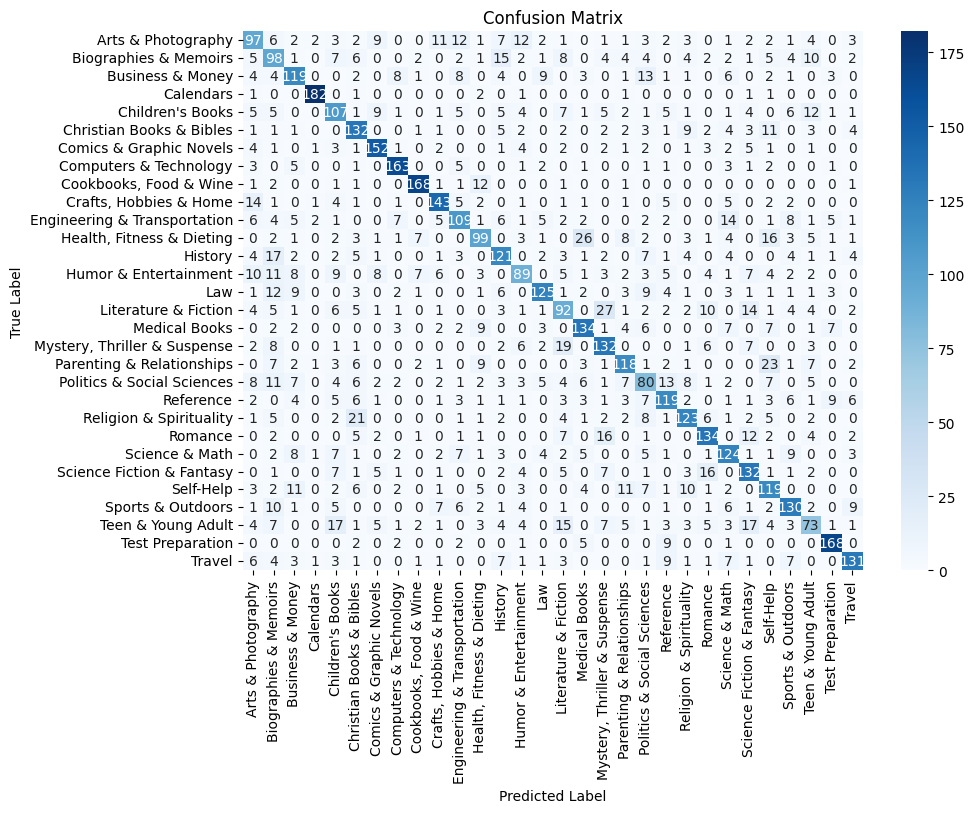

In [22]:
# Print results of the evaluations
print(f"Multimodal Top-1 Accuracy: {top_1_multimodal:.2f}%")
print(f"Multimodal Top-3 Accuracy: {top_3_multimodal:.2f}%")

# Plot the results
class_names = list(label_names)
plot_training_results(all_preds, all_labels)